In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.metrics import RocCurveDisplay,PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics

In [4]:
from datetime import datetime

# Reload Dataset

In [5]:
DATASET = 'home-credit'

In [6]:
X_train = pd.read_csv(f'../dataset/{DATASET}/tmp/tf_train.csv')

In [7]:
X_test = pd.read_csv(f'../dataset/{DATASET}/tmp/tf_test.csv')

In [8]:
y_train = pd.read_csv(f'../dataset/{DATASET}/tmp/train_label.csv')['TARGET']
y_test = pd.read_csv(f'../dataset/{DATASET}/tmp/test_label.csv')['TARGET']

In [9]:
# Check columns
set(X_train.columns) - set(X_test.columns)

set()

In [10]:
# Check label
y_train.unique(), y_test.unique()

(array([1, 0]), array([0, 1]))

In [11]:
feat_cols = X_train.columns

# Modeling

In [12]:
name = 'LogReg'
model = LogisticRegression()

In [13]:
# Fit
model.fit(X_train, y_train)

LogisticRegression()

In [14]:
results = {name: {}}

In [15]:
s_time = datetime.now()
results[name]['y_train_pred'] = model.predict(X_train)
results[name]['y_train_prob'] = model.predict_proba(X_train)
results[name]['y_test_pred'] = model.predict(X_test)
results[name]['y_test_prob'] = model.predict_proba(X_test)
print(name, datetime.now() - s_time)

LogReg 0:00:00.072997


# Evaluation

## ROC, PR, Histogram, Confusion Matrix

In [16]:
def evalute_performance(name,model):
    def evaluate_dataset(dataset):
        print(f'On {dataset}')
        
        y_pred = results[name][f'y_{dataset}_pred']
        y_prob = results[name][f'y_{dataset}_prob']
        y_score = y_prob[:,1] # prob of positive label
        
        if dataset == 'train':
            y_true = y_train
        else:
            y_true = y_test
        
        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
        auc_score = metrics.auc(fpr, tpr)
        print('\tAUC', auc_score)

        # ROC
        fig,axs=plt.subplots(1,3,figsize=(15,5))
        ax0,ax1,ax2 = axs[0], axs[1], axs[2]
        RocCurveDisplay.from_predictions(y_true, y_score, name=name, plot_chance_level=True,ax=ax0,)
        ax0.title.set_text('ROC binary classifibcation')

        # PRC
        PrecisionRecallDisplay.from_predictions(y_true, y_score, name=name, plot_chance_level=True, ax=ax1,)
        ax1.set_title("Precision-Recall curve")
        ax1.legend(loc='best')

        # PDF
        sns.histplot(y_prob,ax=ax2,kde=True)
        ax2.set_title("Probility Distribution")
        plt.show()
        
        # Confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
        plt.show()

        # classification matrix
        print('Classification Report with default threshold=0.5')
        print(metrics.classification_report(y_true, y_pred))
        
    print('======================')
    print(f'Performance of {name}\n')
    evaluate_dataset('train')
    evaluate_dataset('test')
    print('\n\n')

Performance of LogReg

On train
	AUC 0.8878627032597273


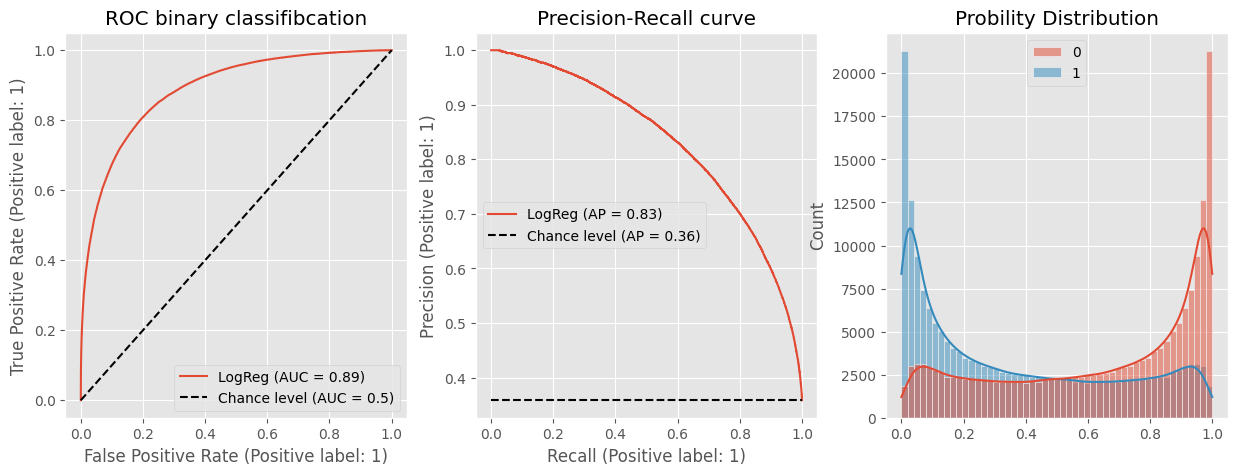

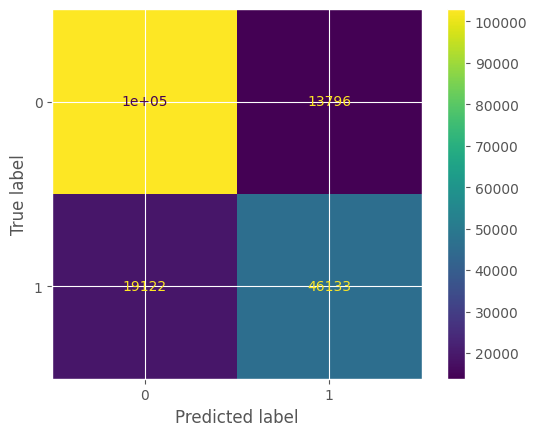

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.84      0.88      0.86    116769
           1       0.77      0.71      0.74     65255

    accuracy                           0.82    182024
   macro avg       0.81      0.79      0.80    182024
weighted avg       0.82      0.82      0.82    182024

On test
	AUC 0.5738510933492873


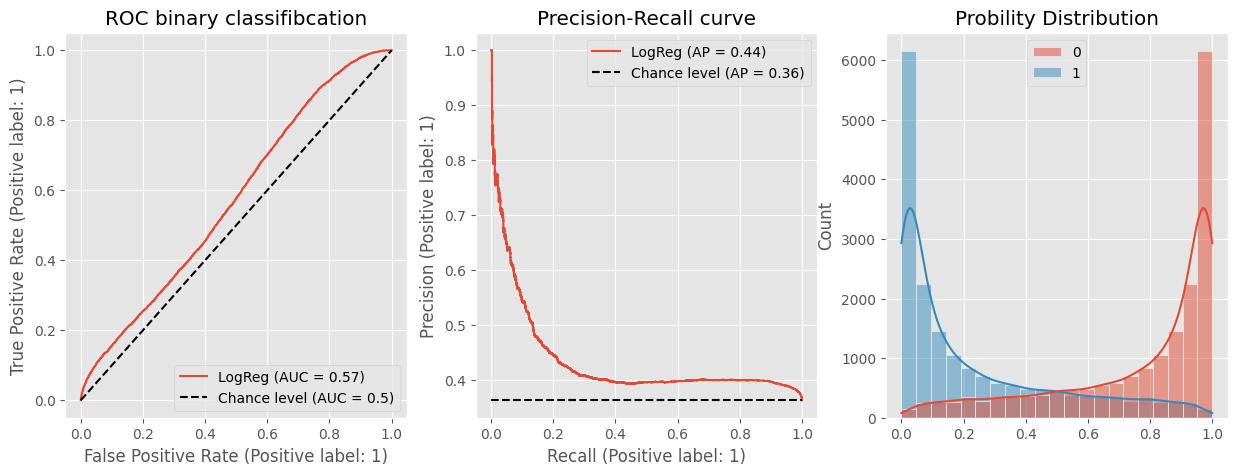

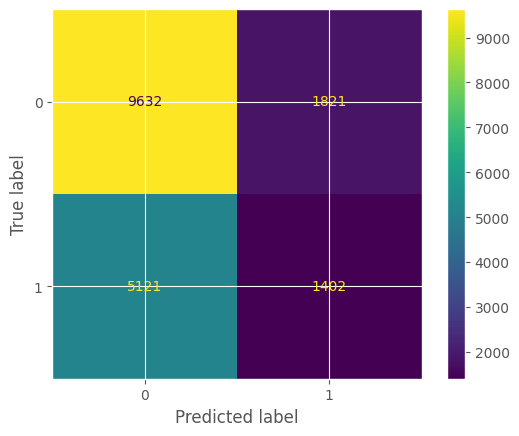

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.65      0.84      0.74     11453
           1       0.43      0.21      0.29      6523

    accuracy                           0.61     17976
   macro avg       0.54      0.53      0.51     17976
weighted avg       0.57      0.61      0.57     17976






In [17]:
evalute_performance(name, model)

## Validation Curve Display

https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_1_3_0.html#new-display-model-selection-validationcurvedisplay

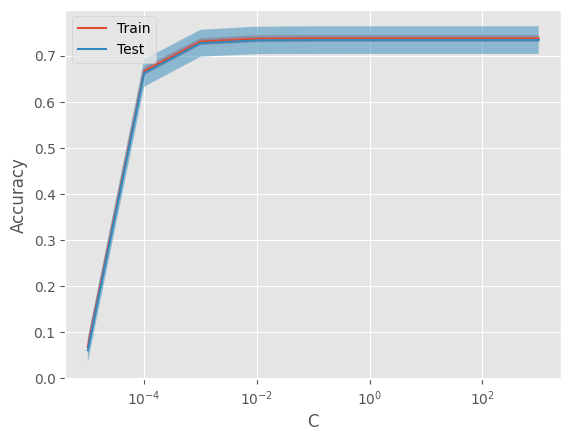

In [31]:
from sklearn.model_selection import ValidationCurveDisplay

X, y = X_train, y_train

_ = ValidationCurveDisplay.from_estimator(
    LogisticRegression(),
    X,
    y,
    param_name="C",
    param_range=np.geomspace(1e-5, 1e3, num=9),
    scoring='f1',
    score_type="both",
    score_name="Accuracy",
)

## LogLoss

In [32]:
from sklearn.metrics import log_loss

In [33]:
y_prob = results[name]['y_test_prob'][:,1]

In [34]:
log_loss(y_test, y_prob)

0.9825250984427784

## Coefficients

In [38]:
coeff_df = pd.Series(model.coef_.ravel(), index=feat_cols).sort_values()

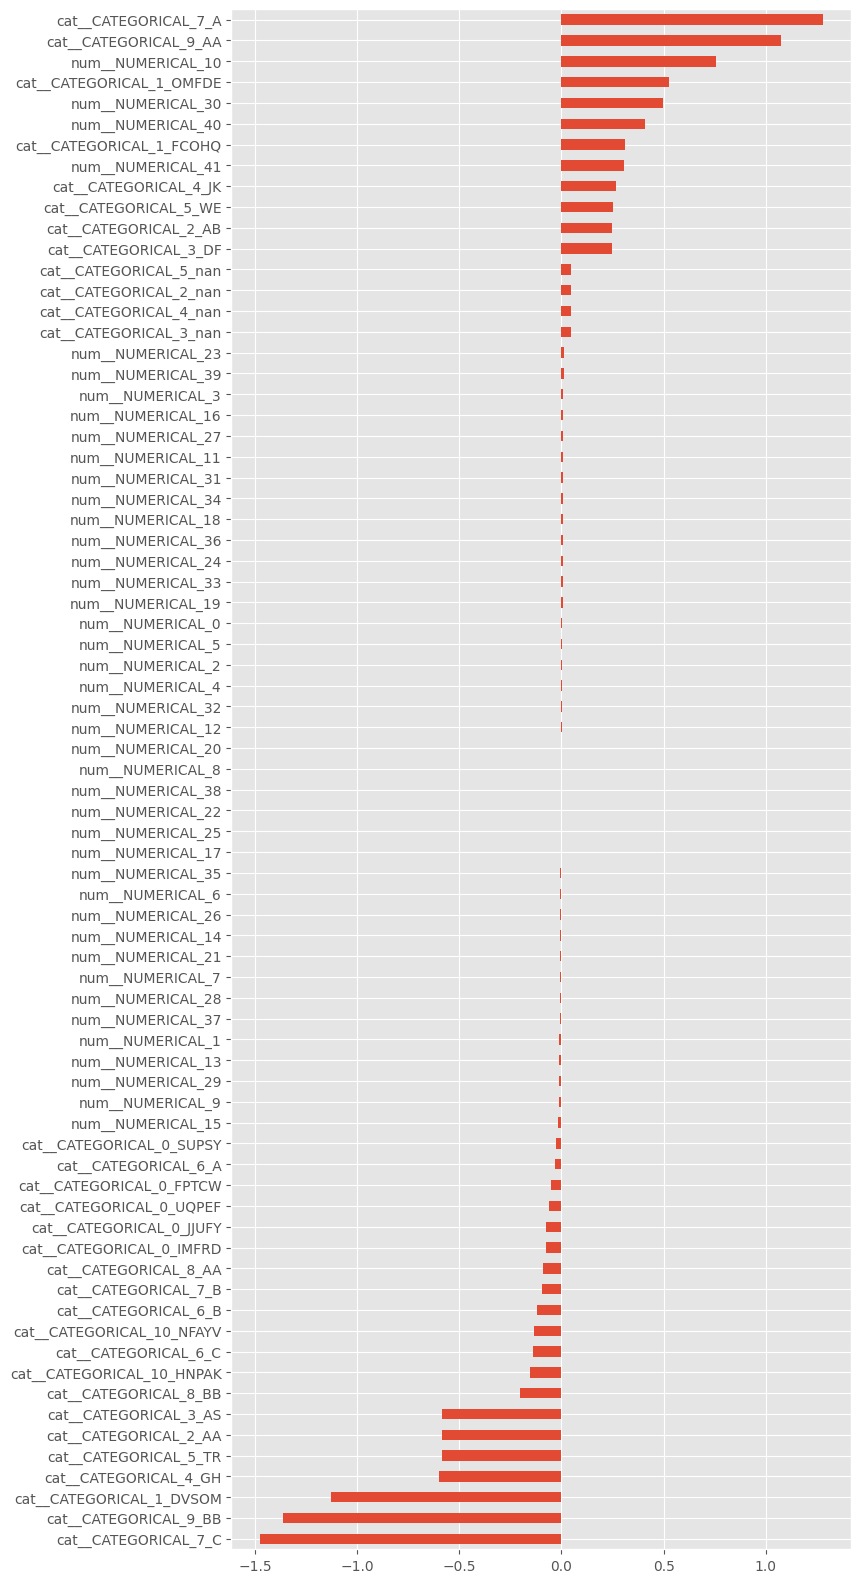

In [39]:
coeff_df.plot.barh(figsize=(8,20))
plt.show()

**References**
- https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf
- https://www.statology.org/interpret-logistic-regression-intercept/
- https://www.statology.org/interpret-logistic-regression-coefficients/

**Introduction**

Logistic regression uses a method known as maximum likelihood estimation to find an equation of the following form 

<center>$logit(p) = log(\frac{p}{1-p}) = \beta_{0} + \beta_{1}X_{1}+ \beta_{2}X_{2} + ... + \beta_{p}X_{p}$</center>

where:

- $\beta_{j}$: the intercept

- $X_{j}$: The jth predictor variable

- $\beta_{j}$: The coefficient estimate for the jth predictor variable

The formula on the right side of the equation predicts the log odds of the response variable taking on a value of 1.

Thus, when we fit a logistic regression model we can use the following equation to calculate the probability that a given observation takes on a value of 1:

<center>$p(X) = \frac{e^{β_{0} + β_{1}X_{1} + β_{2}X_{2} + … + β_{p}X_{p}}}{(1 + e^{β_{0} + β_{1}X_{1} + β_{2}X_{2} + … + β_{p}X_{p}})}$</center>

We then use some probability threshold to classify the observation as either 1 or 0.

**Examples**

In [42]:
coeff_df.sort_values()[::-1]

cat__CATEGORICAL_7_A        1.281844
cat__CATEGORICAL_9_AA       1.073800
num__NUMERICAL_10           0.757585
cat__CATEGORICAL_1_OMFDE    0.527234
num__NUMERICAL_30           0.497845
                              ...   
cat__CATEGORICAL_5_TR      -0.587314
cat__CATEGORICAL_4_GH      -0.601098
cat__CATEGORICAL_1_DVSOM   -1.126792
cat__CATEGORICAL_9_BB      -1.364364
cat__CATEGORICAL_7_C       -1.477891
Length: 74, dtype: float64

In [43]:
model.intercept_

array([-0.2909839])

Let take 2 variables and intercept along with:

1. $β_{0}$ = -0.29 Intercept
2. $β_{1}$ = 1.28 (cat__CATEGORICAL_7_A)
3. $β_{2}$ = 0.75 (num__NUMERICAL_10)

<center>$logit(p) = log(\frac{p}{1-p}) = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2}$</center>

**Intercept**

In term of all X1, X2 are 0 (only $\beta_{0}$ is present), then

$p(X) = \frac{e^{\beta_{0}}}{1 + e^{\beta_{0}}}$

> intercept term in the model output represent the log odds of the response variable occurring when all predictor variables are equal to zero

We can see that the intercept term has a value of -0.29

This means that when X1 is equal to zero (i.e. X1 of CATEGORICAL_7_A is zero) and when X2 is equal to zero (the X2 of NUMERCIAL_10 is zero) the log odds of the ID default are -0.29

Since log odds are hard to understand, we can instead rewrite things in terms of probability:

- Probability of default = $\frac{e^{\beta_{0}}}{1 + e^{\beta_{0}}}$
- Probability of default = $\frac{e^{-0.29}}{1 + e^{-0.29}}$
- Probability of default = 0.428 (42.8%)

In [46]:
np.e**(-0.29) / (1 + np.e**(-0.29))

0.4280038670684814

When both predictor variables are equal to zero (i.e. an ID with non-CATEGORICAL_7_A and no NUMERICAL_10), the repayment probability of that ID is 42.8%

**Coefficient**

When we fit a logistic regression model, the coefficients in the model output represent **the average change in the log odds** of the response variable associated with a one unit increase in the predictor variable

β = Average Change in Log Odds of Response Variable

$e^{β}$ = Average Change in Odds of Response Variable

**Binary Predictor Variable - Category Features**

The coeff of $\beta_{1} = 1.28$ (assume that p_value < 0.05) means that $e^{1.28} = 3.6$

We interpret this to mean that ID has CATEGORICAL_7_A have just 3.6 times the odds of ID without CATEGORICAL_7_A of repaying, assuming the other predictor variable held constant. That being said, the odds for repaying are 260% higher for CATEGORICAL_7_A.

In [48]:
np.e**(1.28)

3.5966397255692812

**Continuous Predictor Variable**

In [50]:
np.e**(0.75)

2.117000016612675

We can see that the coefficient estimate for NUMERICAL_10 is positive, which indicates that each additional NUMERICAL_10 taken increases the chances of repayment.

We assume that the p-value for NUMERICAL_10 taken is less than .05, which means it has a statistically significant effect on whether or not an individual application is repaid.

To quantify how each additional NUMERICAL_10 affects whether or not an individual application is repaid, we can use the formula $e^{\beta}$

$e^{0.75} = 2.12$

We interpret this to mean that each additional NUMERICAL_10 taken multiplies the odds of repayment by 2.12, assuming that CATEGORICAL_7_A is held constant.

We could also say that each additional NUMERICAL_10 taken is associated with a (2.12 – 1) 112% increase in the odds of repayment, again assuming that CATEGORICAL_7_A is held constant.

**Statement**

Logistic regression was used to analyze the relationship between [predictor variable 1], [predictor variable 2], … [predictor variable n] and [response variable].

 

It was found that, holding all other predictor variables constant, the odds of [response variable] occurring [increased or decreased] by [some percent] (95% CI [Lower Limit, Upper Limit]) for a one -unit increase in [predictor variable 1].

 

It was found that, holding all other predictor variables constant, the odds of [response variable] occurring [increased or decreased] by [some percent] (95% CI [Lower Limit, Upper Limit]) for a one -unit increase in [predictor variable 2].

> We should also calculate the 95% confidence interval for the odds ratio of each predictor variable using the formula $e^{β +/- 1.96*std error}$

## Calibration

https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html#sphx-glr-auto-examples-calibration-plot-compare-calibration-py

In [23]:
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.metrics import brier_score_loss

In [24]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

In [25]:
prob_true, prob_pred

(array([0.32592419, 0.3981811 , 0.37556855, 0.35574468, 0.34511435,
        0.35891381, 0.36158192, 0.41114458, 0.4922813 , 0.66983373]),
 array([0.03255701, 0.14418208, 0.24638484, 0.34827021, 0.4502027 ,
        0.54819256, 0.64972308, 0.74996554, 0.84755425, 0.94134402]))

In [26]:
brier_score_loss(y_test, y_prob)

0.29294289405505963

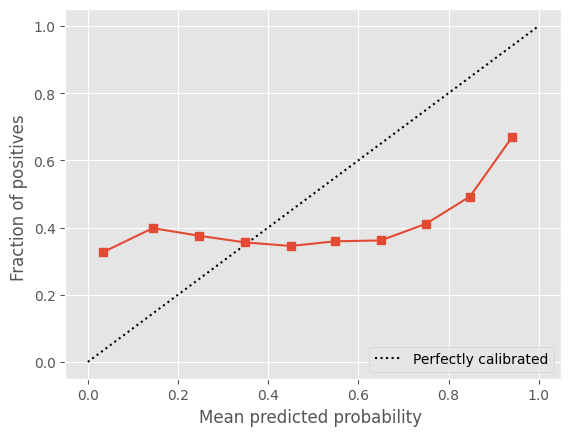

In [27]:
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

## Recursive feature elimination with cross-validation 

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [28]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [29]:
clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="f1",
    min_features_to_select=1,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 22


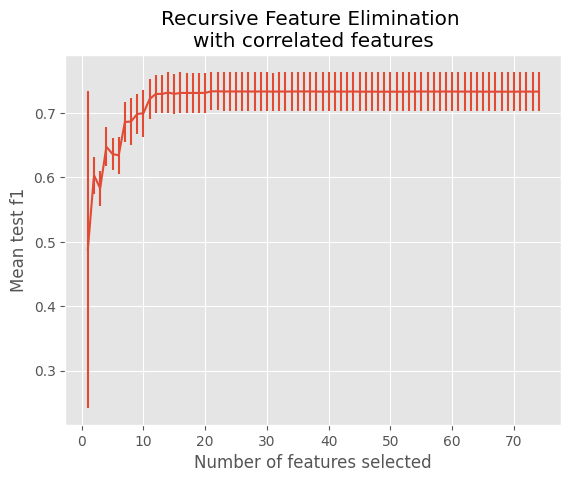

In [30]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test f1")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Test Error Rate with various Heldout 

In [31]:
from sklearn.model_selection import train_test_split

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
# Number of rounds to fit and evaluate an estimator.
rounds = 10

training SAG


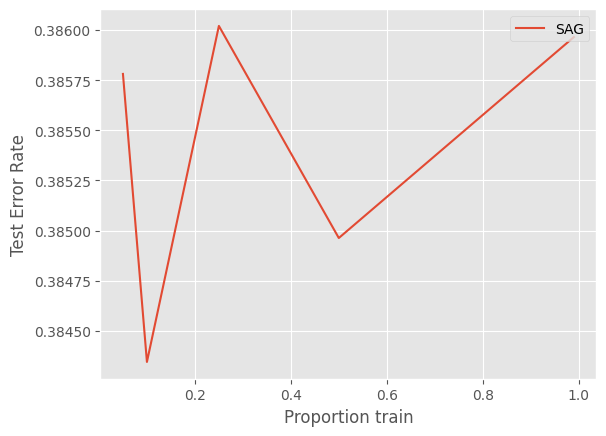

In [32]:
classifiers = [
    (
        "SAG",
        LogisticRegression(max_iter=110, solver="sag", tol=1e-1, C=1.0e4 / X.shape[0]),
    ),
]

xx = 1.0 - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

## L1 Penalty and Sparsity in Logistic Regression

In [34]:
l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

# Set regularization parameter
for i, C in enumerate((1, 0.1, 0.01)):
    # Increase tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty="l1", tol=0.01, solver="saga")
    clf_l2_LR = LogisticRegression(C=C, penalty="l2", tol=0.01, solver="saga")
    clf_en_LR = LogisticRegression(
        C=C, penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01
    )
    clf_l1_LR.fit(X_train, y_train)
    clf_l2_LR.fit(X_train, y_train)
    clf_en_LR.fit(X_train, y_train)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:", sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:", clf_l1_LR.score(X_train, y_train)))
    print("{:<40} {:.2f}".format("Score with Elastic-Net penalty:", clf_en_LR.score(X_train, y_train)))
    print("{:<40} {:.2f}".format("Score with L2 penalty:", clf_l2_LR.score(X_train, y_train)))

C=1.00
Sparsity with L1 penalty:                0.00%
Sparsity with Elastic-Net penalty:       0.00%
Sparsity with L2 penalty:                0.00%
Score with L1 penalty:                   0.82
Score with Elastic-Net penalty:          0.82
Score with L2 penalty:                   0.82
C=0.10
Sparsity with L1 penalty:                0.00%
Sparsity with Elastic-Net penalty:       0.00%
Sparsity with L2 penalty:                0.00%
Score with L1 penalty:                   0.82
Score with Elastic-Net penalty:          0.82
Score with L2 penalty:                   0.82
C=0.01
Sparsity with L1 penalty:                8.11%
Sparsity with Elastic-Net penalty:       1.35%
Sparsity with L2 penalty:                0.00%
Score with L1 penalty:                   0.82
Score with Elastic-Net penalty:          0.82
Score with L2 penalty:                   0.82


## Plot Decision Boundary

In [35]:
from sklearn.inspection import DecisionBoundaryDisplay

In [36]:
selected_cols = ['num__NUMERICAL_30','num__NUMERICAL_10']

In [37]:
X = X_train[selected_cols]  # we only take the first two features.
Y = y_train

In [38]:
# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

LogisticRegression(C=100000.0)

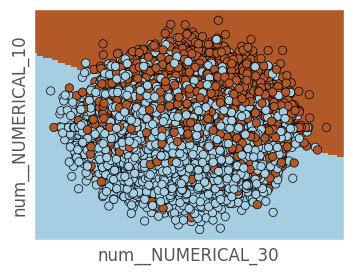

In [39]:
_, ax = plt.subplots(figsize=(4, 3))
DecisionBoundaryDisplay.from_estimator(
    logreg,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel=selected_cols[0],
    ylabel=selected_cols[1],
    eps=0.5,
)

# Plot also the training points
plt.scatter(X[selected_cols[0]], X[selected_cols[1]], c=Y, edgecolors="k", cmap=plt.cm.Paired)
plt.xticks(())
plt.yticks(())
plt.show()

## Chaining PCA with LogReg

https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py

In [40]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/Users/quan/opt/miniconda3/envs/aicv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameter (CV score=0.817):
{'logistic__C': 21.54434690031882, 'pca__n_components': 60}


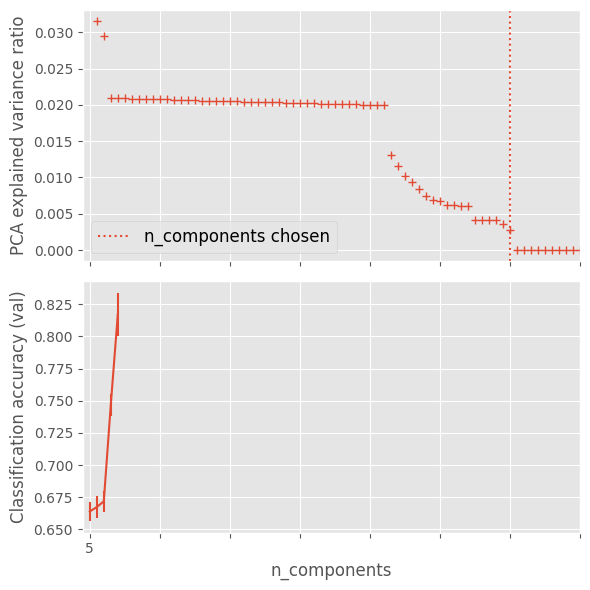

In [41]:
# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

# Further

## Class Likelihood Ratios to measure classification performance

https://scikit-learn.org/stable/auto_examples/model_selection/plot_likelihood_ratios.html#

## Feature discretization

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_classification.html#sphx-glr-auto-examples-preprocessing-plot-discretization-classification-py

## Metric

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

## Learning Curve

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html#sklearn.model_selection.LearningCurveDisplay.from_estimator